In [ ]:
!pip install torch torchvision torchaudio --upgrade
!pip install accelerate



Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable


In [ ]:
!pip install accelerate --upgrade


Defaulting to user installation because normal site-packages is not writeable


In [ ]:
# Install the transformers library if not already available
!pip install transformers

# Now, import the required modules
from transformers import DistilBertTokenizer, DistilBertForSequenceClassification, Trainer, TrainingArguments
from sklearn.model_selection import train_test_split
import numpy as np
from sklearn.metrics import accuracy_score, precision_recall_fscore_support


Defaulting to user installation because normal site-packages is not writeable


In [ ]:
!pip install torch torchvision torchaudio --upgrade
!pip install transformers --upgrade

Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable


In [ ]:
import pandas as pd

# Update the path below to the path of your dataset in Google Drive
#file_path = '/content/drive/My Drive/ADSproject/data/labeled_comments_cleaned.csv'
df = pd.read_csv('labeled_comments_cleaned.csv')


In [ ]:
import re

# Function to clean text data
def clean_text(text):
    # Remove symbols and numbers
    text = re.sub(r'[^a-zA-Z\s]', '', text, re.I|re.A)
    # Convert to lowercase
    text = text.lower()
    # Remove extra spaces
    text = text.strip()
    return text

# Clean the comment_full_text column
df['comment_full_text'] = df['comment_full_text'].apply(clean_text)


In [ ]:
from sklearn.model_selection import train_test_split

# Selecting the feature and target variable
X = df['comment_full_text']
y = df['level_0']

# Splitting the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [ ]:
from transformers import DistilBertTokenizerFast, DistilBertForSequenceClassification, Trainer, TrainingArguments
import torch

# Load the tokenizer
tokenizer = DistilBertTokenizerFast.from_pretrained('distilbert-base-uncased')

# Load the DistilBERT model pre-trained for sequence classification
model = DistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased', num_labels=4) # Adjust num_labels based on your intents


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
# Tokenize the text
train_encodings = tokenizer(X_train.tolist(), truncation=True, padding=True)
test_encodings = tokenizer(X_test.tolist(), truncation=True, padding=True)


In [ ]:
class Dataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

# Convert the y labels to integers
label_dict = {v: k for k, v in enumerate(df['level_0'].unique())}
y_train_int = y_train.replace(label_dict).values
y_test_int = y_test.replace(label_dict).values

# Prepare the dataset
train_dataset = Dataset(train_encodings, y_train_int)
test_dataset = Dataset(test_encodings, y_test_int)


In [ ]:
from transformers import Trainer, TrainingArguments

training_args = TrainingArguments(
    output_dir='./results',          # output directory for model and logs
    num_train_epochs=3,              # total number of training epochs
    learning_rate=2e-5, # you can adjust this learning rate
    per_device_train_batch_size=16,  # batch size per device during training
    per_device_eval_batch_size=64,   # batch size for evaluation
    warmup_steps=500,                # number of warmup steps for learning rate scheduler
    weight_decay=0.01,               # strength of weight decay
    logging_dir='./logs',            # directory for storing logs
    logging_steps=10,
)

trainer = Trainer(
    model=model,                         # the instantiated Transformers model to be trained
    args=training_args,                  # training arguments, defined above
    train_dataset=train_dataset,         # training dataset
    eval_dataset=test_dataset            # evaluation dataset
)


Detected kernel version 4.18.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.


In [ ]:
trainer.train()


/home/spati/.local/lib/python3.11/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


Step,Training Loss
10,1.423600
20,1.406900
30,1.399900
40,1.385000
50,1.360200
60,1.322700
70,1.279600
80,1.219700
90,1.125100
100,1.083300


TrainOutput(global_step=375, training_loss=0.8762604223887126, metrics={'train_runtime': 78.4191, 'train_samples_per_second': 152.718, 'train_steps_per_second': 4.782, 'total_flos': 1499725188428544.0, 'train_loss': 0.8762604223887126, 'epoch': 3.0})

In [ ]:
from transformers import Trainer, TrainingArguments

# Arguments for training
training_args = TrainingArguments(
    # ... other arguments ...
    output_dir='./results',          # output directory for model and logs
    num_train_epochs=2,              # total number of training epochs
    learning_rate=2e-5, # you can adjust this learning rate
    per_device_train_batch_size=8,  # batch size per device during training
    per_device_eval_batch_size=16,   # batch size for evaluation
    warmup_steps=500,                # number of warmup steps for learning rate scheduler
    weight_decay=0.01,               # strength of weight decay
    logging_dir='./logs',            # directory for storing logs
    logging_steps=10,
    gradient_accumulation_steps=2,  # Accumulate gradients
    # fp16=True,  # Enable mixed precision training
    save_steps=200,  # Save model every 200 steps
    save_total_limit=2,  # Only keep the last two checkpoints
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
)

# Training in a loop to save intermittently
for epoch in range(training_args.num_train_epochs):
    # trainer.train(resume_from_checkpoint=True)
    trainer.train()
    trainer.save_model(f"./model_checkpoint_epoch_{epoch}")


Detected kernel version 4.18.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.
/home/spati/.local/lib/python3.11/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


Step,Training Loss
10,0.482000
20,0.510900
30,0.488600
40,0.445800
50,0.532900
60,0.503000
70,0.503200
80,0.530800
90,0.439300
100,0.489000


/home/spati/.local/lib/python3.11/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


Step,Training Loss
10,0.421200
20,0.452400
30,0.417000
40,0.367000
50,0.449000
60,0.415900
70,0.412900
80,0.449400
90,0.364200
100,0.405400


/home/spati/.local/lib/python3.11/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


In [ ]:
trainer.evaluate()

{'eval_loss': 0.6240663528442383,
 'eval_runtime': 2.1026,
 'eval_samples_per_second': 475.123,
 'eval_steps_per_second': 15.219,
 'epoch': 2.0}

In [ ]:
from sklearn.metrics import accuracy_score

# Assuming predictions are made using the Trainer's predict method on the test dataset
predictions = trainer.predict(test_dataset)

# Get the predicted labels by taking the argmax of the logits from the predictions
predicted_labels = np.argmax(predictions.predictions, axis=-1)

# Calculate accuracy using the true labels and the predicted labels
accuracy = accuracy_score(predictions.label_ids, predicted_labels)

# The test error rate is 1 minus the accuracy
test_error_rate = 1 - accuracy

print(f"Test Error Rate: {test_error_rate:.3f}")


Test Error Rate: 0.231


In [ ]:
from transformers import DistilBertTokenizer, DistilBertForSequenceClassification
import torch

# Make sure to load the model and tokenizer
model_name = "distilbert-base-uncased"  # Replace with your model name if different
tokenizer = DistilBertTokenizer.from_pretrained(model_name)
model = DistilBertForSequenceClassification.from_pretrained(model_name)

# Move the model to the appropriate device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Example sentences for prediction
sentences = [
    "Can we include the latest survey data in our analysis?",
    "Great teamwork on the recent launch, everyone should be proud!",
    "Where can I find the financial report for Q2?"
]

# Tokenize the sentences
encoded_inputs = tokenizer(sentences, padding=True, truncation=True, return_tensors="pt")

# Move the tokenized inputs to the device
input_ids = encoded_inputs["input_ids"].to(device)
attention_mask = encoded_inputs["attention_mask"].to(device)

# Predict
model.eval()  # Set the model to evaluation mode
with torch.no_grad():
    outputs = model(input_ids, attention_mask=attention_mask)

# Get the predictions
logits = outputs.logits
predictions = torch.argmax(logits, dim=-1)

# Move predictions back to CPU for further operations if needed
predictions = predictions.detach().cpu().numpy()

# Convert the predictions to label names if you have a mapping
# If using a model from Hugging Face with an associated config, you can convert the indices to labels directly
label_names = [model.config.id2label[pred] for pred in predictions]

# Output the predictions
for sentence, label in zip(sentences, label_names):
    print(f"Text: '{sentence}'\nPredicted intent: {label}\n")


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Text: 'Can we include the latest survey data in our analysis?'
Predicted intent: LABEL_1

Text: 'Great teamwork on the recent launch, everyone should be proud!'
Predicted intent: LABEL_1

Text: 'Where can I find the financial report for Q2?'
Predicted intent: LABEL_1



In [ ]:
from transformers import DistilBertTokenizer, DistilBertForSequenceClassification, Trainer, TrainingArguments
import torch

# Initialize the tokenizer
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')

# Initialize the model
model = DistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased', num_labels=4) # Replace NUM_LABELS with the actual number of labels in your task

# Tokenize the input texts
texts = [
    "Can we include the latest survey data in our analysis?",
    "Great teamwork on the recent launch, everyone should be proud!",
    "Where can I find the financial report for Q2?"
]
inputs = tokenizer(texts, padding=True, truncation=True, return_tensors="pt")

# Move the model and inputs to the GPU if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)
inputs = inputs.to(device)

# Define the training arguments
training_args = TrainingArguments(
    output_dir='./results',          # output directory for model and logs
    num_train_epochs=5,              # total number of training epochs
    per_device_train_batch_size=16,  # batch size per device during training
    per_device_eval_batch_size=64,   # batch size for evaluation
    warmup_steps=500,                # number of warmup steps for learning rate scheduler
    weight_decay=0.01,               # strength of weight decay
    logging_dir='./logs',            # directory for storing logs
    logging_steps=10,
)

# Initialize the Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,  # replace with your actual training dataset
    eval_dataset=test_dataset,    # replace with your actual evaluation dataset
)

# Train and evaluate
trainer.train()
trainer.evaluate()

# Make predictions
model.eval()  # Put the model in evaluation mode
with torch.no_grad():
    logits = model(**inputs).logits

# Convert logits to class labels
predictions = torch.argmax(logits, dim=-1).cpu().numpy()

# Map the predictions to actual labels (you need to replace LABEL_MAPPING with your actual label mapping)
LABEL_MAPPING = {0: "Information Exchange", 1: "Modification", 2: "Social Communication", 3: "Other"}  # Replace with actual mapping
predicted_labels = [LABEL_MAPPING[label] for label in predictions]

# Print the predictions
for text, label in zip(texts, predicted_labels):
    print(f'Text: "{text}"\nPredicted intent: {label}\n')

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Detected kernel version 4.18.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.
/home/spati/.local/lib/python3.11/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


Step,Training Loss
10,1.400500
20,1.384600
30,1.361900
40,1.318600
50,1.256500
60,1.179100
70,1.078400
80,1.032100
90,0.942400
100,0.952800


/home/spati/.local/lib/python3.11/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


Text: "Can we include the latest survey data in our analysis?"
Predicted intent: Information Exchange

Text: "Great teamwork on the recent launch, everyone should be proud!"
Predicted intent: Social Communication

Text: "Where can I find the financial report for Q2?"
Predicted intent: Information Exchange



In [ ]:
from sklearn.metrics import accuracy_score

# Assuming predictions are made using the Trainer's predict method on the test dataset
predictions = trainer.predict(test_dataset)

# Get the predicted labels by taking the argmax of the logits from the predictions
predicted_labels = np.argmax(predictions.predictions, axis=-1)

# Calculate accuracy using the true labels and the predicted labels
accuracy = accuracy_score(predictions.label_ids, predicted_labels)

# The test error rate is 1 minus the accuracy
test_error_rate = 1 - accuracy

print(f"Test Error Rate: {test_error_rate:.3f}")

Test Error Rate: 0.217


In [ ]:
from transformers import DistilBertTokenizer, DistilBertForSequenceClassification
import torch

# Initialize the tokenizer
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')

# Texts to predict
texts_to_predict = [
    "Is there an update on the project timeline?",
    "Congratulations on reaching your sales targets!",
    "Could you provide me with the meeting minutes?",
    "Let's schedule a review meeting for Monday."
]

# Tokenize the texts
inputs = tokenizer(texts_to_predict, padding=True, truncation=True, return_tensors="pt")

# Move the inputs to the same device as the model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
inputs = inputs.to(device)

# Initialize the model
model = DistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased', num_labels=4)  # Replace num_labels with your actual number
model.to(device)

# Get the model's predictions
model.eval()  # Set the model to evaluation mode
with torch.no_grad():
    outputs = model(**inputs)
    predictions = torch.argmax(outputs.logits, dim=-1)

# Map predictions to the actual labels
# Replace this with your actual label mapping
label_mapping = {0: 'Information Exchange', 1: 'Modification', 2: 'Social Communication', 3: 'Other'}
predicted_labels = [label_mapping[pred.item()] for pred in predictions]

# Display predictions
for text, label in zip(texts_to_predict, predicted_labels):
    print(f'Text: "{text}"\nPredicted intent: {label}\n')


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Text: "Is there an update on the project timeline?"
Predicted intent: Information Exchange

Text: "Congratulations on reaching your sales targets!"
Predicted intent: Information Exchange

Text: "Could you provide me with the meeting minutes?"
Predicted intent: Information Exchange

Text: "Let's schedule a review meeting for Monday."
Predicted intent: Information Exchange



In [ ]:
# Install the required packages if running in a Google Colab environment
# !pip install transformers datasets sklearn

import pandas as pd
from sklearn.model_selection import train_test_split
from transformers import DistilBertTokenizerFast, DistilBertForSequenceClassification, Trainer, TrainingArguments
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
import numpy as np
from datasets import Dataset

# Define a function to compute metrics for evaluation
def compute_metrics(pred):
    labels = pred.label_ids
    preds = np.argmax(pred.predictions, axis=1)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='weighted')
    acc = accuracy_score(labels, preds)
    return {
        'accuracy': acc,
        'f1': f1,
        'precision': precision,
        'recall': recall
    }

# Load the dataset
data = pd.read_csv('labeled_comments_cleaned.csv')  # Replace with your file path

# Preprocess your data if necessary (e.g., you might want to clean text data)

# Map labels to integers
label_list = data['level_0'].unique().tolist()
label_to_id = {label: i for i, label in enumerate(label_list)}
id_to_label = {i: label for label, i in label_to_id.items()}

# Split the data
train_data, val_data = train_test_split(data, test_size=0.1)
train_data['labels'] = train_data['level_0'].map(label_to_id)
val_data['labels'] = val_data['level_0'].map(label_to_id)

# Load the tokenizer
tokenizer = DistilBertTokenizerFast.from_pretrained('distilbert-base-uncased')

# Tokenize the text
def tokenize(batch):
    return tokenizer(batch['comment_full_text'], padding=True, truncation=True)

# Create Hugging Face datasets
train_dataset = Dataset.from_pandas(train_data)
val_dataset = Dataset.from_pandas(val_data)

# Tokenize datasets
train_dataset = train_dataset.map(tokenize, batched=True, remove_columns=['comment_full_text', 'level_0'])
val_dataset = val_dataset.map(tokenize, batched=True, remove_columns=['comment_full_text', 'level_0'])

# Convert datasets to the Torch format
train_dataset.set_format(type='torch', columns=['input_ids', 'attention_mask', 'labels'])
val_dataset.set_format(type='torch', columns=['input_ids', 'attention_mask', 'labels'])

# Load the model
model = DistilBertForSequenceClassification.from_pretrained(
    'distilbert-base-uncased',
    num_labels=len(label_list)
)

# Define training args
training_args = TrainingArguments(
    output_dir='./results',
    num_train_epochs=3,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=32,
    warmup_steps=500,
    weight_decay=0.01,
    logging_dir='./logs',
    evaluation_strategy='epoch',
    save_strategy='epoch',
)

# Initialize the Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics
)

# Train the model
trainer.train()

# Save the model
model_path = "./trained_model"
model.save_pretrained(model_path)
tokenizer.save_pretrained(model_path)


Map:   0%|          | 0/4491 [00:00<?, ? examples/s]

Map:   0%|          | 0/500 [00:00<?, ? examples/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/home/spati/.local/lib/python3.11/site-packages/transformers/training_args.py:1474: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
Detected kernel version 4.18.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.
/home/spati/.local/lib/python3.11/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  war

Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,No log,0.765223,0.678000,0.619058,0.583113,0.678000
2,No log,0.659774,0.738000,0.739428,0.754041,0.738000
3,No log,0.543980,0.782000,0.780763,0.783258,0.782000


/software/slurm/spackages/linux-rocky8-x86_64/gcc-12.2.0/anaconda3-2023.09-0-3mhml42fa64byxqyd5fig5tbih625dp2/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/spati/.local/lib/python3.11/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/home/spati/.local/lib/python3.11/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


('./trained_model/tokenizer_config.json',
 './trained_model/special_tokens_map.json',
 './trained_model/vocab.txt',
 './trained_model/added_tokens.json',
 './trained_model/tokenizer.json')

In [ ]:
from transformers import DistilBertTokenizerFast, DistilBertForSequenceClassification
import torch

# Load trained model and tokenizer
model_path = './trained_model'
tokenizer = DistilBertTokenizerFast.from_pretrained(model_path)
model = DistilBertForSequenceClassification.from_pretrained(model_path)

# Function to make predictions
def predict(texts):
    # Tokenize the texts
    encoded_input = tokenizer(texts, padding=True, truncation=True, return_tensors='pt')

    # Move tensor to the right device
    encoded_input.to(model.device)

    # Get predictions
    with torch.no_grad():
        output = model(**encoded_input)

    # Convert logits to probabilities
    probabilities = torch.nn.functional.softmax(output.logits, dim=-1)

    # Get the predicted class indices
    predictions = torch.argmax(probabilities, dim=-1).cpu().numpy()

    # Convert predicted class indices to labels
    predicted_labels = [id_to_label[idx] for idx in predictions]
    return predicted_labels

# Example usage:
texts = [
    "Can we include the latest survey data in our analysis?",
    "Great teamwork on the recent launch, everyone should be proud!",
    "Where can I find the financial report for Q2?"
]

predicted_labels = predict(texts)
print(predicted_labels)


['INFORMATION EXCHANGE', 'SOCIAL COMMUNICATION', 'INFORMATION EXCHANGE']


In [ ]:
from transformers import DistilBertTokenizer, DistilBertForSequenceClassification
import torch

# Make sure to replace 'path_to_your_model' with the actual path where your model is saved
model_path = './trained_model'
model = DistilBertForSequenceClassification.from_pretrained(model_path)
tokenizer = DistilBertTokenizer.from_pretrained(model_path)

# Put your model in evaluation mode
model.eval()

# Define your new examples here
examples = [
    "Is there an update on the project timeline?",
    "Congratulations on reaching your sales targets!",
    "Could you provide me with the meeting minutes?",
    "Let's schedule a review meeting for Monday."
]

# Tokenize and predict the intents of the new examples
for example in examples:
    inputs = tokenizer(example, return_tensors='pt', padding=True, truncation=True, max_length=512)
    with torch.no_grad():
        logits = model(**inputs).logits
    predicted_label = logits.argmax(dim=-1).item()

    # Convert the predicted label index to the actual label name, replace this with your actual label names
    label_names = ['Information Exchange', 'Modification', 'Social Communication', 'Other']
    predicted_intent = label_names[predicted_label]

    print(f"Text: '{example}'")
    print(f"Predicted intent: {predicted_intent}")


Text: 'Is there an update on the project timeline?'
Predicted intent: Information Exchange
Text: 'Congratulations on reaching your sales targets!'
Predicted intent: Social Communication
Text: 'Could you provide me with the meeting minutes?'
Predicted intent: Information Exchange
Text: 'Let's schedule a review meeting for Monday.'
Predicted intent: Social Communication


In [ ]:
from sklearn.metrics import classification_report, mean_squared_error
from sklearn.model_selection import train_test_split
from transformers import DistilBertTokenizerFast, DistilBertForSequenceClassification, Trainer, TrainingArguments
from datasets import Dataset
import pandas as pd
import numpy as np

# Load the dataset
df = pd.read_csv('labeled_comments_cleaned.csv')  # Adjust path

# Map your text and labels (assuming 'text' is the text and 'label' is the label)
df['text'] = df['comment_full_text']  # Change to your text column name
df['label'] = df['level_0'].astype('category').cat.codes  # Change to your label column name

# Split the data into train and validation sets
train_df, val_df = train_test_split(df, test_size=0.1)

# Tokenize the text
tokenizer = DistilBertTokenizerFast.from_pretrained('distilbert-base-uncased')
train_encodings = tokenizer(train_df['text'].tolist(), truncation=True, padding=True)
val_encodings = tokenizer(val_df['text'].tolist(), truncation=True, padding=True)

# Convert to datasets
train_dataset = Dataset.from_dict({**train_encodings, 'labels': train_df['label'].tolist()})
val_dataset = Dataset.from_dict({**val_encodings, 'labels': val_df['label'].tolist()})

# Define the model
model = DistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased', num_labels=df['label'].nunique())

# Define training arguments
training_args = TrainingArguments(
    output_dir='./results',
    num_train_epochs=3,
    per_device_train_batch_size=16,
    evaluation_strategy='epoch'
)

# Define the compute_metrics function for evaluation
def compute_metrics(pred):
    labels = pred.label_ids
    preds = np.argmax(pred.predictions, axis=-1)
    accuracy = accuracy_score(labels, preds)
    f1 = f1_score(labels, preds, average='weighted')
    precision = precision_score(labels, preds, average='weighted')
    recall = recall_score(labels, preds, average='weighted')
    mse = mean_squared_error(labels, preds)
    return {
        'accuracy': accuracy,
        'f1': f1,
        'precision': precision,
        'recall': recall,
        'mse': mse
    }

# Initialize the Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics
)

# Train the model
trainer.train()

# Make predictions on the validation set
predictions = trainer.predict(val_dataset)
pred_labels = np.argmax(predictions.predictions, axis=-1)

# Print classification report
print(classification_report(val_df['label'], pred_labels))

# Print mean squared error
print("Mean Squared Error (MSE):", mean_squared_error(val_df['label'], pred_labels))


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/home/spati/.local/lib/python3.11/site-packages/transformers/training_args.py:1474: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
Detected kernel version 4.18.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.
/home/spati/.local/lib/python3.11/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  war

Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall,Mse
1,No log,0.562880,0.776000,0.775401,0.781659,0.776000,0.592000
2,No log,0.546271,0.812000,0.812512,0.814901,0.812000,0.482000
3,No log,0.556984,0.788000,0.786969,0.788130,0.788000,0.558000


/home/spati/.local/lib/python3.11/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/home/spati/.local/lib/python3.11/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/home/spati/.local/lib/python3.11/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


              precision    recall  f1-score   support

           0       0.80      0.84      0.82       258
           1       0.76      0.76      0.76       165
           2       0.90      0.74      0.81        35
           3       0.72      0.62      0.67        42

    accuracy                           0.79       500
   macro avg       0.80      0.74      0.76       500
weighted avg       0.79      0.79      0.79       500

Mean Squared Error (MSE): 0.558


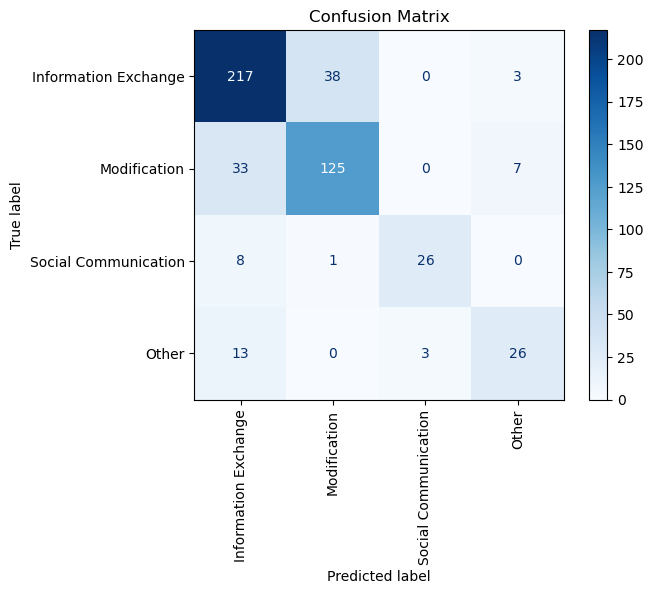

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
cm = confusion_matrix(val_df['label'], pred_labels)

# Define label names (make sure these are in the same order as your encoded labels)
label_names = ['Information Exchange', 'Modification', 'Social Communication', 'Other']

# Display confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_names)
disp.plot(cmap=plt.cm.Blues, xticks_rotation='vertical')
plt.title('Confusion Matrix')
plt.show()


In [ ]:
from sklearn.metrics import accuracy_score

# Assume `true_labels` are your true validation labels and `pred_labels` are the predicted labels from your model
true_labels = val_df['label'].tolist()

# Calculate accuracy
accuracy = accuracy_score(true_labels, pred_labels)

# Test error rate is 1 - accuracy
test_error_rate = 1 - accuracy

print(f"Test Error Rate: {test_error_rate:.3f}")


Test Error Rate: 0.212


In [ ]:
from transformers import DistilBertTokenizer, Trainer, TrainingArguments, DistilBertForSequenceClassification
import pandas as pd
from datasets import Dataset
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
import numpy as np

# Load the dataset
test_dataframe = pd.read_csv('labeled_comments_cleaned.csv')

# Initialize the tokenizer
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')

# Tokenize the test dataset
test_encodings = tokenizer(test_dataframe['comment_full_text'].tolist(), truncation=True, padding='max_length', max_length=512)

# Correct the label_to_id dictionary to match the case used in your dataframe
label_to_id = {
    'Information Exchange': 0,
    'Modification': 1,
    'Social Communication': 2,
    'Other': 3
}

# Ensure your dataframe 'level_0' column has labels that match the keys in label_to_id
# If not, you need to convert them to match. Here's how you can do it:
test_dataframe['level_0'] = test_dataframe['level_0'].str.title()  # Convert to title case to match keys

# Convert the list of labels to the correct format, mapping each label to its corresponding ID
true_labels = [label_to_id[label] for label in test_dataframe['level_0']]

# Create a test dataset
test_dataset = Dataset.from_dict({'input_ids': test_encodings['input_ids'], 'attention_mask': test_encodings['attention_mask'], 'labels': true_labels})

# Load the pre-trained model
model = DistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased', num_labels=len(label_to_id))

# Define training arguments
training_args = TrainingArguments(
    output_dir='./results',
    do_predict=True
)

# Define the Trainer
trainer = Trainer(
    model=model,
    args=training_args
)

# Make predictions
predictions = trainer.predict(test_dataset)

# Convert the predictions to labels
pred_labels = np.argmax(predictions.predictions, axis=-1)

# Calculate metrics
def compute_metrics(p):
    pred_labels = np.argmax(p.predictions, axis=-1)
    accuracy = accuracy_score(p.label_ids, pred_labels)
    f1 = f1_score(p.label_ids, pred_labels, average='weighted')
    precision = precision_score(p.label_ids, pred_labels, average='weighted')
    recall = recall_score(p.label_ids, pred_labels, average='weighted')
    return {"accuracy": accuracy, "f1": f1, "precision": precision, "recall": recall}

# Initialize the Trainer with compute_metrics
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,  # Assuming train_dataset is available
    eval_dataset=val_dataset,  # Assuming val_dataset is available
    compute_metrics=compute_metrics  # Pass the compute_metrics function here
)

# Evaluate the model
eval_results = trainer.evaluate(eval_dataset=test_dataset, metric_key_prefix="test")
print(eval_results)

# Remember to save the trained model and tokenizer if needed
model_path = "./trained_model"
model.save_pretrained(model_path)
tokenizer.save_pretrained(model_path)







Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Detected kernel version 4.18.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.
/home/spati/.local/lib/python3.11/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


Detected kernel version 4.18.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.


/software/slurm/spackages/linux-rocky8-x86_64/gcc-12.2.0/anaconda3-2023.09-0-3mhml42fa64byxqyd5fig5tbih625dp2/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


{'test_loss': 1.340157151222229, 'test_accuracy': 0.4628330995792426, 'test_f1': 0.34607972815874055, 'test_precision': 0.34252765231591636, 'test_recall': 0.4628330995792426, 'test_runtime': 15.1899, 'test_samples_per_second': 328.573, 'test_steps_per_second': 20.54}


('./trained_model/tokenizer_config.json',
 './trained_model/special_tokens_map.json',
 './trained_model/vocab.txt',
 './trained_model/added_tokens.json')

Accuracy: 0.46
Precision: 0.34
Recall: 0.46
F1 Score: 0.35


/software/slurm/spackages/linux-rocky8-x86_64/gcc-12.2.0/anaconda3-2023.09-0-3mhml42fa64byxqyd5fig5tbih625dp2/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


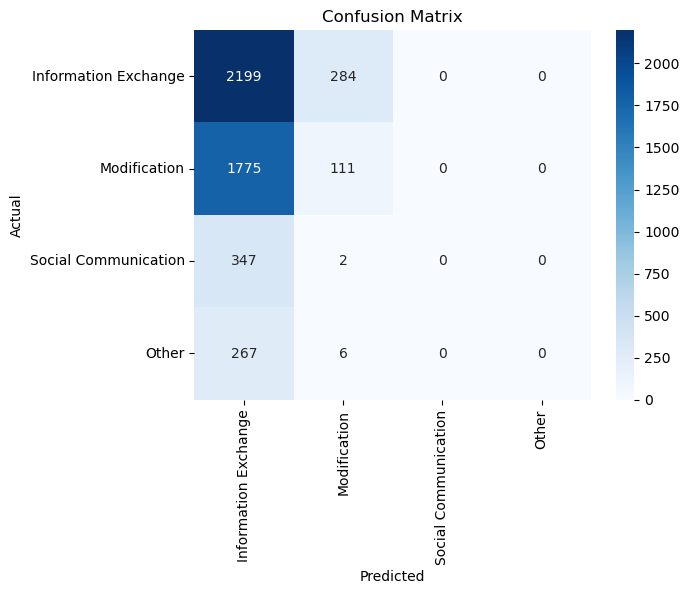

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming `true_labels` and `pred_labels` are your actual and predicted labels respectively

# Calculate metrics
accuracy = accuracy_score(true_labels, pred_labels)
precision = precision_score(true_labels, pred_labels, average='weighted')  # Use 'micro', 'macro', 'weighted', or 'binary' for binary classification
recall = recall_score(true_labels, pred_labels, average='weighted')        # Use 'micro', 'macro', 'weighted', or 'binary' for binary classification
f1 = f1_score(true_labels, pred_labels, average='weighted')                # Use 'micro', 'macro', 'weighted', or 'binary' for binary classification

# Print the metrics
print(f"Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1 Score: {f1:.2f}")

# Generate and visualize the confusion matrix
cm = confusion_matrix(true_labels, pred_labels)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=label_names, yticklabels=label_names)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix')
plt.show()


In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from transformers import DistilBertTokenizerFast, DistilBertForSequenceClassification, Trainer, TrainingArguments
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
import numpy as np
from datasets import Dataset

# Define a function to compute metrics for evaluation
def compute_metrics(pred):
    labels = pred.label_ids
    preds = np.argmax(pred.predictions, axis=1)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='weighted')
    acc = accuracy_score(labels, preds)
    return {
        'accuracy': acc,
        'f1': f1,
        'precision': precision,
        'recall': recall
    }

# Load the dataset
data = pd.read_csv('labeled_comments_cleaned.csv')  # Replace with your file path

# Preprocess your data if necessary (e.g., you might want to clean text data)

# Map labels to integers
label_list = data['level_0'].unique().tolist()
label_to_id = {label: i for i, label in enumerate(label_list)}
id_to_label = {i: label for label, i in label_to_id.items()}

# Split the data
train_data, val_data = train_test_split(data, test_size=0.1)
train_data['labels'] = train_data['level_0'].map(label_to_id)
val_data['labels'] = val_data['level_0'].map(label_to_id)

# Load the tokenizer
tokenizer = DistilBertTokenizerFast.from_pretrained('distilbert-base-uncased')

# Tokenize the text
def tokenize(batch):
    return tokenizer(batch['comment_full_text'], padding=True, truncation=True)

# Create Hugging Face datasets
train_dataset = Dataset.from_pandas(train_data)
val_dataset = Dataset.from_pandas(val_data)

# Tokenize datasets
train_dataset = train_dataset.map(tokenize, batched=True, remove_columns=['comment_full_text', 'level_0'])
val_dataset = val_dataset.map(tokenize, batched=True, remove_columns=['comment_full_text', 'level_0'])

# Convert datasets to the Torch format
train_dataset.set_format(type='torch', columns=['input_ids', 'attention_mask', 'labels'])
val_dataset.set_format(type='torch', columns=['input_ids', 'attention_mask', 'labels'])

# Load the model
model = DistilBertForSequenceClassification.from_pretrained(
    'distilbert-base-uncased',
    num_labels=len(label_list)
)

# Define training args
training_args = TrainingArguments(
    output_dir='./results',
    num_train_epochs=3,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=32,
    warmup_steps=500,
    weight_decay=0.01,
    logging_dir='./logs',
    evaluation_strategy='epoch',
    save_strategy='epoch',
)

# Initialize the Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics
)

# Train the model
trainer.train()

# Save the model
model_path = "./trained_model"
model.save_pretrained(model_path)
tokenizer.save_pretrained(model_path)

Map:   0%|          | 0/4491 [00:00<?, ? examples/s]

Map:   0%|          | 0/500 [00:00<?, ? examples/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/home/spati/.local/lib/python3.11/site-packages/transformers/training_args.py:1474: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
Detected kernel version 4.18.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.
/home/spati/.local/lib/python3.11/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  war

Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,No log,0.775278,0.678000,0.619165,0.588503,0.678000
2,No log,0.664673,0.742000,0.742325,0.755988,0.742000
3,No log,0.577033,0.752000,0.752658,0.766962,0.752000


/software/slurm/spackages/linux-rocky8-x86_64/gcc-12.2.0/anaconda3-2023.09-0-3mhml42fa64byxqyd5fig5tbih625dp2/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/spati/.local/lib/python3.11/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/home/spati/.local/lib/python3.11/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


('./trained_model/tokenizer_config.json',
 './trained_model/special_tokens_map.json',
 './trained_model/vocab.txt',
 './trained_model/added_tokens.json',
 './trained_model/tokenizer.json')

In [ ]:
from transformers import DistilBertTokenizerFast, DistilBertForSequenceClassification
import torch

# Load trained model and tokenizer
model_path = './trained_model'
tokenizer = DistilBertTokenizerFast.from_pretrained(model_path)
model = DistilBertForSequenceClassification.from_pretrained(model_path)

# Function to make predictions
def predict(texts):
    # Tokenize the texts
    encoded_input = tokenizer(texts, padding=True, truncation=True, return_tensors='pt')

    # Move tensor to the right device
    encoded_input.to(model.device)

    # Get predictions
    with torch.no_grad():
        output = model(**encoded_input)

    # Convert logits to probabilities
    probabilities = torch.nn.functional.softmax(output.logits, dim=-1)

    # Get the predicted class indices
    predictions = torch.argmax(probabilities, dim=-1).cpu().numpy()

    # Convert predicted class indices to labels
    predicted_labels = [id_to_label[idx] for idx in predictions]
    return predicted_labels

# Example usage:
texts = [
    "Can we include the latest survey data in our analysis?",
    "Great teamwork on the recent launch, everyone should be proud!",
    "Where can I find the financial report for Q2?"
]

predicted_labels = predict(texts)
print(predicted_labels)



['INFORMATION EXCHANGE', 'SOCIAL COMMUNICATION', 'INFORMATION EXCHANGE']


Accuracy: 0.46
Precision: 0.34
Recall: 0.46
F1 Score: 0.35


/software/slurm/spackages/linux-rocky8-x86_64/gcc-12.2.0/anaconda3-2023.09-0-3mhml42fa64byxqyd5fig5tbih625dp2/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


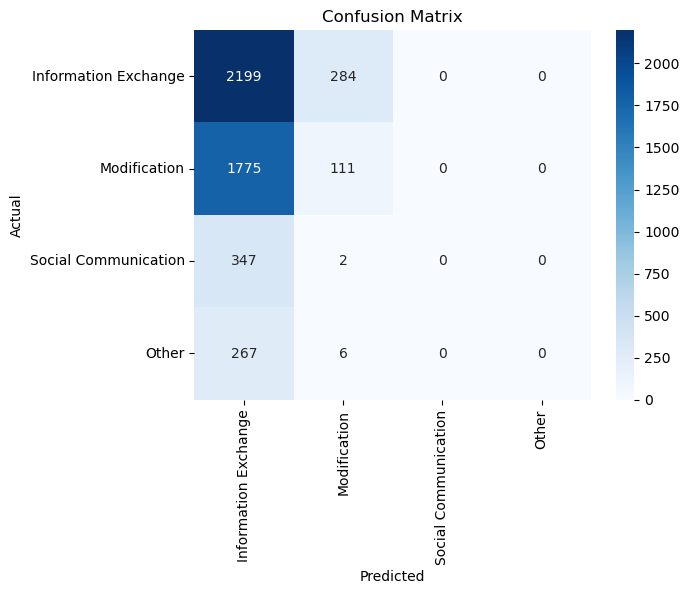

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming `true_labels` and `pred_labels` are your actual and predicted labels respectively

# Calculate metrics
accuracy = accuracy_score(true_labels, pred_labels)
precision = precision_score(true_labels, pred_labels, average='weighted')  # Use 'micro', 'macro', 'weighted', or 'binary' for binary classification
recall = recall_score(true_labels, pred_labels, average='weighted')        # Use 'micro', 'macro', 'weighted', or 'binary' for binary classification
f1 = f1_score(true_labels, pred_labels, average='weighted')                # Use 'micro', 'macro', 'weighted', or 'binary' for binary classification

# Print the metrics
print(f"Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1 Score: {f1:.2f}")

# Generate and visualize the confusion matrix
cm = confusion_matrix(true_labels, pred_labels)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=label_names, yticklabels=label_names)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix')
plt.show()